This notebook is used to evaluate the accuracy of the OPERA DSWx product using the outputs of our model as a reference.

In [1]:
# GIS imports
import rasterio
from rasterio.merge import merge
from rasterio.warp import transform_bounds
from rasterio.crs import CRS
from rasterio.plot import show
from rasterio.windows import from_bounds
from shapely.geometry import box
from rasterio.mask import mask
from rasterio import features
from shapely.geometry import Polygon
from shapely.ops import unary_union                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
import geopandas as gpd
from tools import get_geopandas_features_from_array, resample_labels_into_percentage, reclassify_percentage_array_for_dswx
from dem_stitcher.rio_window import read_raster_from_window
from dem_stitcher.rio_tools import reproject_arr_to_match_profile, update_profile_resolution

# matplotlib imports
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import PercentFormatter

# sklearn imports
import sklearn
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import sklearn.metrics
import numpy as np

# misc imports
import pandas as pd
from pathlib import Path
from itertools import starmap
from pandas import json_normalize
import warnings
from tqdm import tqdm

In [2]:
EQUAL_SAMPLING = True  # if false currently uses validation labels to determine size of each class sample
TOTAL_PIXELS_PER_SAMPLE = 15_000
NUMBER_OF_RANDOM_SAMPLES = 100  # aka number of trials
SAMPLE_FROM_DSWX = False # either sample from validation data or dswx (note this does not impact class sizes)
USE_ENTIRE_IMAGE = False # if True, random sampling and trials is moot and just directly samples from entire image
WITH_REPLACEMENT = False # whether to replace samples - will ensure equality if present, untested
CONFIDENCE_CLASSES = []#[0, 1, 2, 3] # Confidence classes to be included (if empty include ALL)
DOWNSAMPLE_BOTH_DS_TO_3_HA = False # downsample both datasets to 3 ha
USE_AEROSOL_MASK = False
NUMBER_OF_RANDOM_SAMPLES = 100
REWRITE_TO_METRICS_TABLE=True
PLANET_ID = "20210903_150800_60_2458"

For any given validation dataset, we will consider the source Planet image and the overlapping DSWx tile to calculate statistics.

In [3]:
df = pd.read_csv('../data/new_validation_table.csv')
df.head()

,Unnamed: 0,planet_id,site_name,dswx_files,conf_files,val_files,rf_classification_files
0,0,20210903_150800_60_2458,4_21,../data/20210903_150800_60_2458/dswx/OPERA_L3_...,../data/20210903_150800_60_2458/dswx/OPERA_L3_...,../data/planet_images_cropped/20210903_150800_...,../data/planet_images_cropped/20210903_150800_...
1,1,20210903_152641_60_105c,4_11,../data/20210903_152641_60_105c/dswx/OPERA_L3_...,../data/20210903_152641_60_105c/dswx/OPERA_L3_...,../data/planet_images_cropped/20210903_152641_...,../data/planet_images_cropped/20210903_152641_...
2,2,20210904_093422_44_1065,1_31,../data/20210904_093422_44_1065/dswx/OPERA_L3_...,../data/20210904_093422_44_1065/dswx/OPERA_L3_...,../data/planet_images_cropped/20210904_093422_...,../data/planet_images_cropped/20210904_093422_...
3,3,20210906_101112_28_225a,3_28,../data/20210906_101112_28_225a/dswx/OPERA_L3_...,../data/20210906_101112_28_225a/dswx/OPERA_L3_...,../data/planet_images_cropped/20210906_101112_...,../data/planet_images_cropped/20210906_101112_...
4,4,20210909_000649_94_222b,1_37,../data/20210909_000649_94_222b/dswx/OPERA_L3_...,../data/20210909_000649_94_222b/dswx/OPERA_L3_...,../data/planet_images_cropped/20210909_000649_...,../data/planet_images_cropped/20210909_000649_...


In [4]:
row = df[df.planet_id==PLANET_ID]
site_name = row['site_name'].values[0]
dswx_file = row['dswx_files'].values[0].split()[0]
conf_file = row['conf_files'].values[0].split()[0]
classification_file = row['rf_classification_files'].values[0].split()[0]
val_files = row['val_files'].values[0].split()[0]

In [6]:
df = pd.read_csv('../data/metrics.csv')
row = df[df['planet_id'] == PLANET_ID]
old_accuracy_psw_mean = round(100*row['acc_per_class.Partial_Surface_Water.mean'].values[0], 2)
old_accuracy_osw_mean = round(100*row['acc_per_class.Open_Surface_Water.mean'].values[0], 2)
old_accuracy_bwater_acc_mean = round(100*row['binary_water_acc.mean'].values[0], 2)

old_accuracy_psw_std = round(100*row['acc_per_class.Partial_Surface_Water.std'].values[0], 2)
old_accuracy_osw_std = round(100*row['acc_per_class.Open_Surface_Water.std'].values[0], 2)
old_accuracy_bwater_acc_std = round(100*row['binary_water_acc.std'].values[0], 2)

We need to resample RF outputs to the DSWx resolution. We need to account for Fmask and no data, and also mask out water bodies that are smaller than 3 ha

In [7]:
with rasterio.open(dswx_file) as ds:
    dswx_crs = ds.crs
    dswx_profile = ds.profile
    dswx_img = ds.read(1)

# Create a shape from the valid DSWx data
mask_ = dswx_img != dswx_profile['nodata']
shapes = features.shapes(mask_.astype(np.uint8), mask=mask_, transform=dswx_profile['transform'])
dswx_gdf = gpd.GeoDataFrame(geometry=[unary_union([Polygon(s[0]['coordinates'][0]) for s in shapes]).buffer(1e-5)], crs=dswx_crs)

with rasterio.open(classification_file) as ds:
    val_crs = ds.crs
    val_profile = ds.profile
    val_img = ds.read(1)

# Create a shape from the valid validation data
mask_ = val_img != val_profile['nodata']
shapes = features.shapes(mask_.astype(np.uint8), mask=mask_, transform=val_profile['transform'])
val_gdf = gpd.GeoDataFrame(geometry=[unary_union([Polygon(s[0]['coordinates'][0]) for s in shapes]).buffer(1e-5)], crs=val_crs)

In [8]:
# with rasterio.open(fmask_file) as ds:
#     X_fmask = ds.read(1)
#     p_fmask = ds.profile

# # with rasterio.open(conf_file) as ds:
# #     X_conf = ds.read(1)
# #     p_conf = ds.profile

# # Generate masks to block out regions over which we do not compare DSWx/RF outputs
# # 224 is the ocean mask class
# X_224 = (X_fmask == 224)

# # 160 is ??
# X_160 = (X_fmask == 160)

# X_aerosol = X_224 | X_160

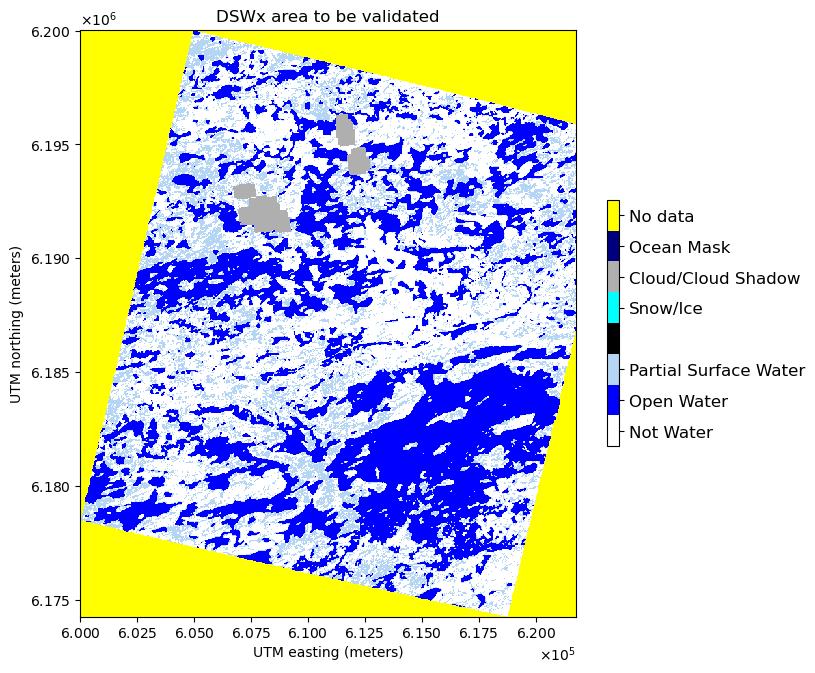

In [9]:
# shape to extract overlap window between dswx and validation
intersection_shape = gpd.GeoDataFrame(geometry = [val_gdf.to_crs(dswx_crs).iloc[0].geometry.intersection(dswx_gdf.iloc[0].geometry)], crs=dswx_crs)

# read window
with rasterio.open(dswx_file) as ds:
    X_dswx, X_dswx_out_transform = mask(ds, intersection_shape.iloc[0], crop=True)
    X_dswx_out_meta = ds.meta
    colormap = ds.colormap(1)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# setting up the colormap/colorbar
colormap.update({255:(255, 255, 0, 255)}) # set "no data" as 'yellow' in RGBA format
cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])
bounds =  [0, 1, 2, 3, 251, 252, 253, 254, 255]
norm = colors.BoundaryNorm(bounds, cmap.N)

ax.set_title("DSWx area to be validated")
ax.set_xlabel('UTM easting (meters)')
ax.set_ylabel('UTM northing (meters)')
ax.ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)

# display image
im = show(X_dswx, transform = dswx_profile['transform'], cmap=cmap, vmin=0, vmax=255, ax=ax, interpolation='none')
im_dswx = im.get_images()[0]

# draw colorbar
cbar=fig.colorbar(im_dswx, ax=ax, shrink=0.4, boundaries=bounds, cmap=cmap, ticks=[0.5, 1.5, 2.5, 251.5, 252.5, 253.5, 254.5])
cbar.set_ticklabels(['Not Water', 'Open Water','Partial Surface Water','Snow/Ice','Cloud/Cloud Shadow', 'Ocean Mask', 'No data'],fontsize=12)

# update profile associated with DSWx tile to account for cropped window
X_dswx_out_meta.update({"driver": "GTiff",
                 "height": X_dswx.shape[1],
                 "width": X_dswx.shape[2],
                 "transform": X_dswx_out_transform})

X_dswx = np.squeeze(X_dswx)

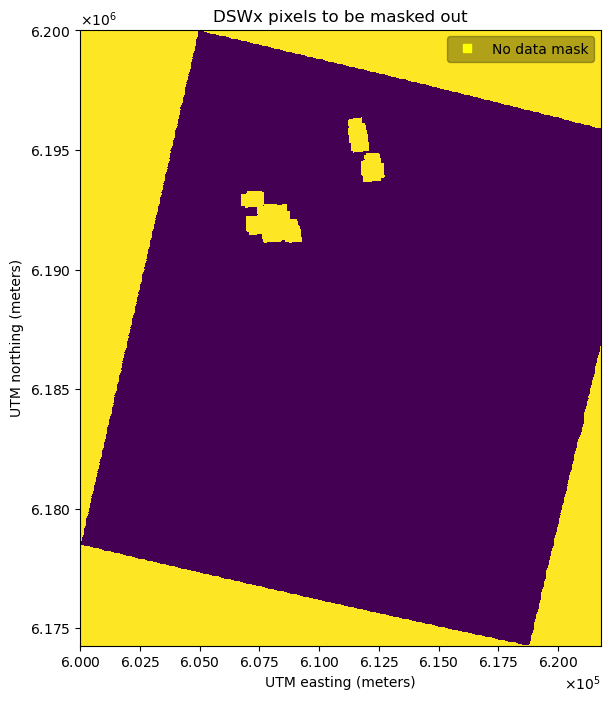

In [10]:
shared_mask = ~np.isin(X_dswx, [0, 1, 2])

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.set_title("DSWx pixels to be masked out")
ax.set_xlabel('UTM easting (meters)')
ax.set_ylabel('UTM northing (meters)')
ax.ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)

_ = show(shared_mask, transform = dswx_profile['transform'], ax=ax, interpolation='none')
ax.plot([], [], 's', color='yellow')
ax.legend(['No data mask'], loc='upper right', fontsize='medium', framealpha=0.3, edgecolor='black', facecolor='black')

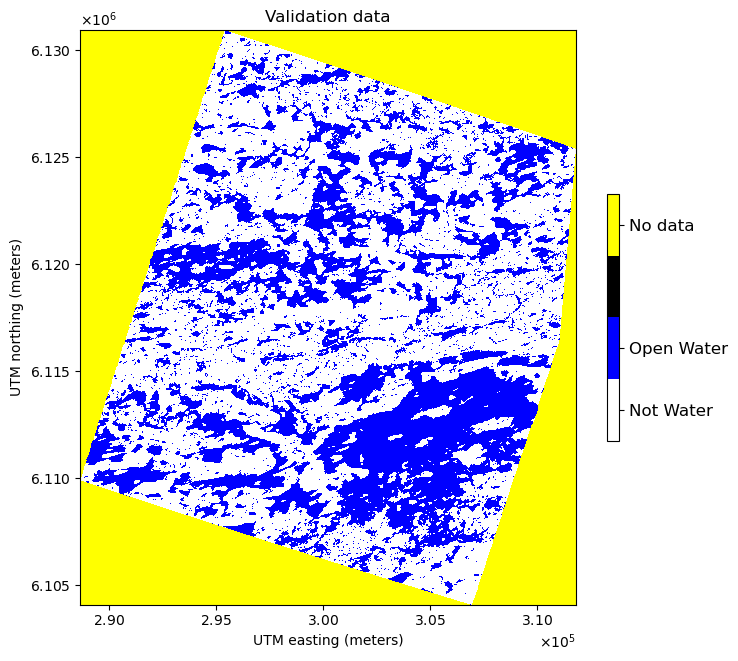

In [11]:
# shape to extract overlap window between dswx and validation
intersection_shape = gpd.GeoDataFrame(geometry = [dswx_gdf.to_crs(val_crs).iloc[0].geometry.intersection(val_gdf.iloc[0].geometry)], crs=val_crs)

# read window
with rasterio.open(classification_file) as ds:
    X_val, X_val_out_transform = mask(ds, intersection_shape.iloc[0], all_touched=True, crop=True)
    X_val_out_meta = ds.meta

X_val_out_meta.update({"driver": "GTiff",
                 "height": X_val.shape[1],
                 "width": X_val.shape[2],
                 "transform": X_val_out_transform})

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# setting up the colormap/colorbar
cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])
bounds =  [0, 1, 2, 254, 255]
norm = colors.BoundaryNorm(bounds, cmap.N)

ax.set_title("Validation data")
ax.set_xlabel('UTM easting (meters)')
ax.set_ylabel('UTM northing (meters)')
ax.ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)

# display image
im = show(X_val[0], transform = val_profile['transform'], cmap=cmap, vmin=0, vmax=255, ax=ax, interpolation='none')
im_val = im.get_images()[0]

# draw colorbar
cbar=fig.colorbar(im_val, ax=ax, shrink=0.4, boundaries=bounds, cmap=cmap, ticks=[0.5, 1.5, 254.5])
cbar.set_ticklabels(['Not Water', 'Open Water', 'No data'],fontsize=12)


Text(0.5, 1.0, 'Open water mask')

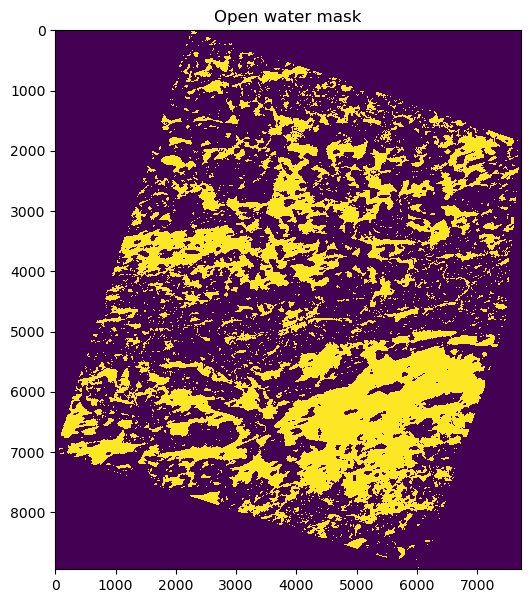

In [12]:
X_val = np.squeeze(X_val)
X_val_water_only = (X_val == 1).astype(int)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(X_val_water_only, interpolation='none')
ax.set_title("Open water mask")

In [13]:
water_labels = label(X_val_water_only, connectivity=2)
water_labels_rbg = label2rgb(water_labels)
props = regionprops(water_labels)

if props:
    print(props[0].area)

4207.0


Text(0.5, 1.0, 'Connected open surface water regions')

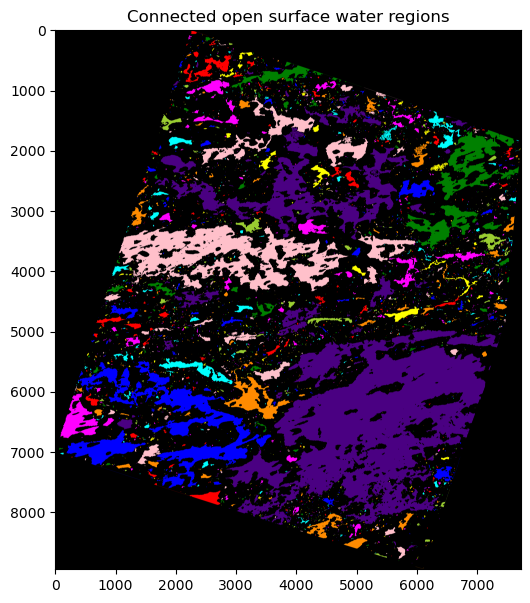

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(water_labels_rbg)
ax.set_title("Connected open surface water regions")

In [15]:
N = min(len(props), 4)
for k in range(N):
    print('key/size label: ', k)
    print('One way:', (water_labels == (k+1)).sum())
    print('region props: ', props[k].area)

key/size label:  0
One way: 4207
region props:  4207.0
key/size label:  1
One way: 57
region props:  57.0
key/size label:  2
One way: 71
region props:  71.0
key/size label:  3
One way: 1700
region props:  1700.0


In [16]:
# mask out water bodies that are smaller than 3 ha
# for 3 m pixels, this converts to contiguous areas that contain 3333.33 pixels
labels_to_exclude = [(k+1) for (k, prop) in enumerate(props) if prop.area <= 3334]
size_mask = np.isin(water_labels, labels_to_exclude)

Text(0.5, 1.0, 'Water bodies to be excluded')

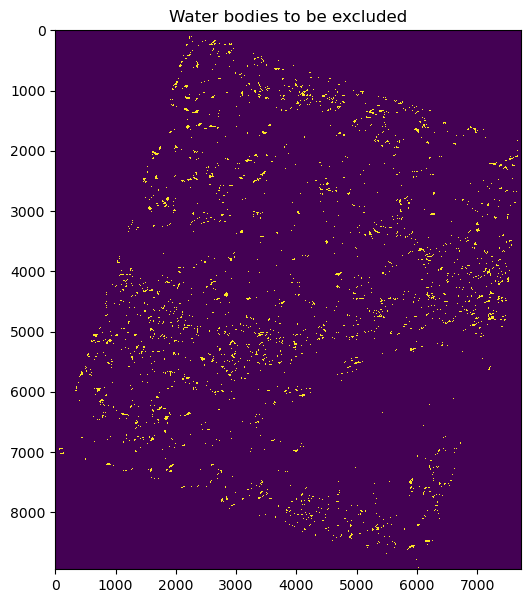

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(size_mask, interpolation='none')
ax.set_title('Water bodies to be excluded')

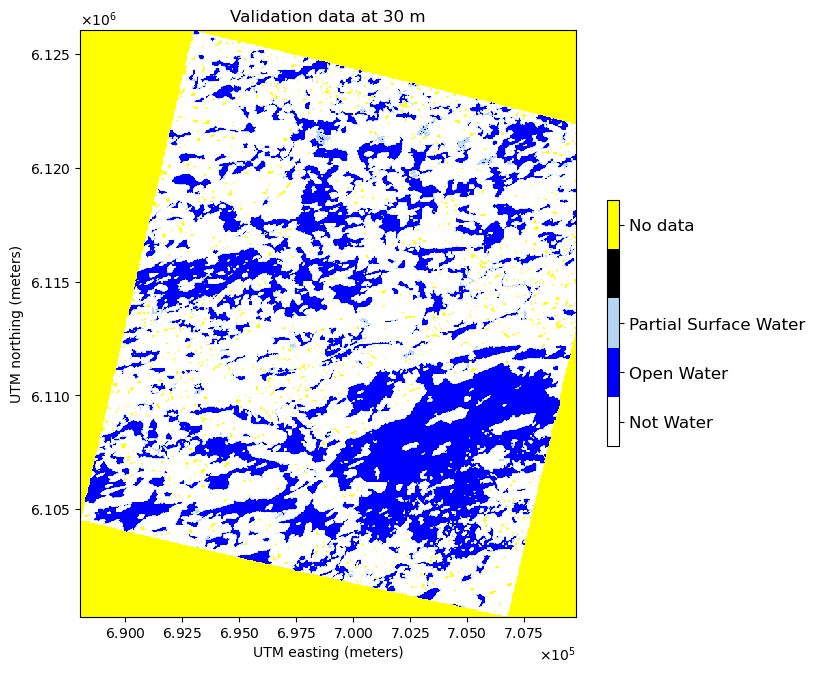

In [18]:
X_dswx_out_meta_copy = X_dswx_out_meta.copy()
X_dswx_out_meta_copy.update({'dtype':'float32'})

p_val_c_3ha_temp = update_profile_resolution(X_val_out_meta, 30)
p_val_c_3ha_temp['dtype'] = 'float32'

# Remove will not classify (10), no data (255), and water bodies < 3 ha
X_val_temp = X_val.astype('float32')
X_val_temp[(X_val == 10) | (X_val == 255) | size_mask] = np.nan
X_val_out_meta_copy = X_val_out_meta.copy()
X_val_out_meta_copy['nodata'] = np.nan

X_val_per_w, p_per_int = resample_labels_into_percentage(X_val_temp, X_val_out_meta_copy, X_dswx_out_meta_copy, 1)
X_val_r = reclassify_percentage_array_for_dswx(X_val_per_w)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# setting up the colormap/colorbar
cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])
bounds =  [0, 1, 2, 3, 254, 255]
norm = colors.BoundaryNorm(bounds, cmap.N)

# display image
ax.set_title("Validation data at 30 m")
ax.set_xlabel('UTM easting (meters)')
ax.set_ylabel('UTM northing (meters)')
ax.ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)

im = show(X_val_r, transform = p_per_int['transform'], cmap=cmap, vmin=0, vmax=255, ax=ax, interpolation='none')
im_val = im.get_images()[0]

# draw colorbar
cbar=fig.colorbar(im_val, ax=ax, shrink=0.4, boundaries=bounds, cmap=cmap, ticks=[0.5, 1.5, 2.5, 254.5])
cbar.set_ticklabels(['Not Water', 'Open Water', 'Partial Surface Water', 'No data'],fontsize=12)

In [19]:
# write out decimated validation dataset for offline reference
X_val_r_temp = X_val_r.copy()
X_val_r_temp[shared_mask] = 253 # Real "no data" regions will also get color coded as clouds, but we don't care
p_per_int_temp = p_per_int.copy()
p_per_int_temp['dtype'] = 'uint8'
p_per_int_temp['nodata'] = 255 

cl_path_temp, cl_name_temp = Path(classification_file).parent, Path(classification_file).name
cl_name_temp = cl_path_temp / f"decimated_{cl_name_temp}"

with rasterio.open(cl_name_temp, 'w', **p_per_int_temp) as ds:
    ds.write(X_val_r_temp.reshape(1, *X_val_r_temp.shape))

Text(0.5, 1.0, 'Regions that will be masked out for calculations')

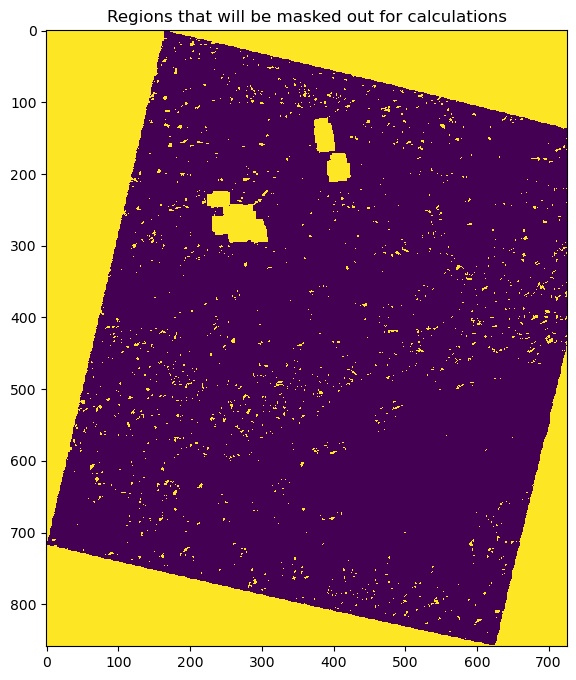

In [20]:
# Combine areas in DSWx containing values not in [0, 1, 2], and areas in Val that are no-data
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
shared_mask = ((X_val_r == 255) | shared_mask)
ax.imshow(shared_mask, interpolation='none')
ax.set_title("Regions that will be masked out for calculations")

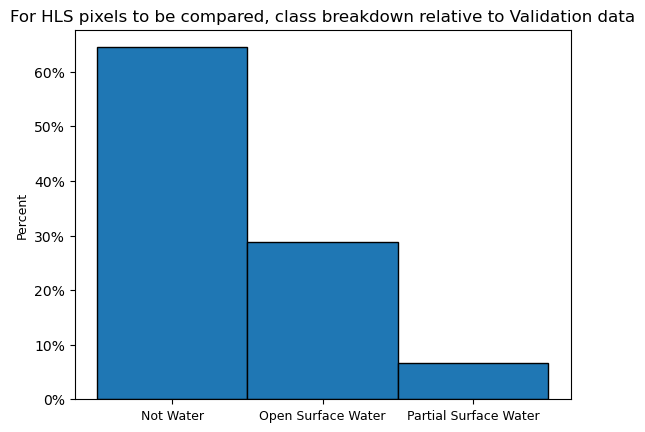

In [21]:
# Validation data histogram 
percents, _, _ = plt.hist(X_val_r[~shared_mask], bins=3, range=(0, 3), density=True, edgecolor='black')
plt.xticks(np.arange(0, 3)+.5, ['Not Water', 'Open Surface Water', 'Partial Surface Water'],fontsize=9)
plt.ylabel('Percent',fontsize=9)
plt.title('For HLS pixels to be compared, class breakdown relative to Validation data');
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

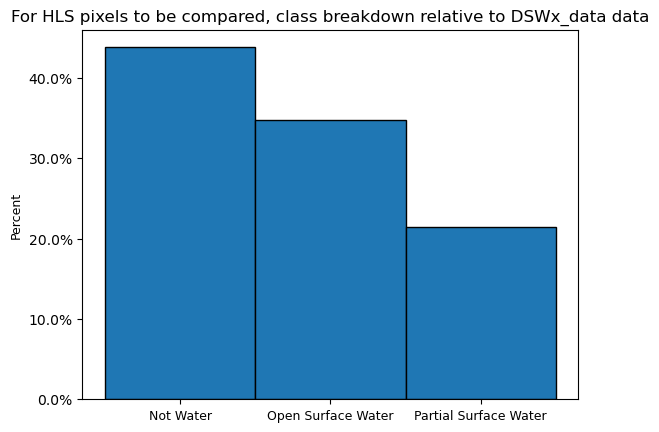

In [22]:
# DSWx data histogram
percents_dswx, _, _ = plt.hist(X_dswx[~shared_mask], bins=3, range=(0, 3), density=True, edgecolor='black')
plt.xticks(np.arange(0, 3)+.5, ['Not Water', 'Open Surface Water', 'Partial Surface Water'],fontsize=9)
plt.ylabel('Percent',fontsize=9)
plt.title('For HLS pixels to be compared, class breakdown relative to DSWx_data data');
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

In [23]:
# print percentage distribution of pixels in DSWx
[100*p for p in percents_dswx]

[43.808892402866036, 34.71110105695555, 21.48000654017842]

In [24]:
sample_size_per_label = [int(np.ceil(percents[label] * TOTAL_PIXELS_PER_SAMPLE)) for label in [0, 1, 2]]
if EQUAL_SAMPLING:
    present_classes = (percents > 0).sum()
    #always multiply by 3 because we have 3 labels
    # sample sizes are modified depending on availability (see cell below)
    sample_size_per_label = [int(np.ceil(TOTAL_PIXELS_PER_SAMPLE / present_classes))] * 3
    
sample_size_per_label

[4000, 4000, 4000]

In [25]:
validation_hls_pixels = X_val_r[~shared_mask]
dswx_hls_pixels = X_dswx[~shared_mask]

sample_pixels = dswx_hls_pixels if SAMPLE_FROM_DSWX else validation_hls_pixels

sample_str = 'dswx' if SAMPLE_FROM_DSWX else 'the validation dataset'
print(f'We are sampling from {sample_str}')

We are sampling from the validation dataset


In [26]:
stratified_selection = [[] for _ in range(NUMBER_OF_RANDOM_SAMPLES)] 

for random_sample in range(NUMBER_OF_RANDOM_SAMPLES):
    for label in [0, 1, 2]:
        # Sampling from PRODUCT PIXELS now
        indices = np.argwhere(sample_pixels == label).ravel()

        # Determines if there are enough samples otherwise select the total number of samples available
        subset_size = sample_size_per_label[label]
        if not WITH_REPLACEMENT:
            subset_size = np.minimum(subset_size, len(indices))
            sample_size_per_label[label] = subset_size

        indices_subset = np.random.choice(indices, subset_size, replace=WITH_REPLACEMENT)
        stratified_selection[random_sample].append(indices_subset)
sample_size_per_label

[4000, 4000, 4000]

In [27]:
X_samples = np.full(shared_mask.shape, 0)
temp = X_samples[~shared_mask]

k = 1

RANDOM_SAMPLE_FOR_INSPECTION = 10
    
sample2validation = {}
sample2dswx = {}

for label in [0, 1, 2]:
    for ind in stratified_selection[RANDOM_SAMPLE_FOR_INSPECTION][label]:
        temp[ind] = k
        # ensure we can look up the sample id and find the correct label for the different datasets we compare
        sample2validation[k] = label
        sample2dswx[k] = dswx_hls_pixels[ind]
        k += 1
    
X_samples[~shared_mask] = temp
(X_samples > 0).sum()

12000

In [28]:
features_ = get_geopandas_features_from_array(# Note 8 bits is not enough for 500 points
                                             X_samples.astype(np.int32), 
                                             transform=X_dswx_out_meta['transform'],
                                             mask=(X_samples==0),
                                             label_name='sample_id'
                                            )
df_samples = gpd.GeoDataFrame.from_features(features_, 
                                            crs=X_dswx_out_meta['crs'])
df_samples['val_label'] = df_samples['sample_id'].map(lambda label: sample2validation[label])
df_samples['dswx_label'] = df_samples['sample_id'].map(lambda label: sample2dswx[label])

df_samples.head()

,geometry,sample_id,val_label,dswx_label
0,"POLYGON ((693090.000 6126000.000, 693090.000 6...",4689.0,1,1
1,"POLYGON ((693120.000 6126000.000, 693120.000 6...",4184.0,1,1
2,"POLYGON ((693030.000 6125880.000, 693030.000 6...",8935.0,2,1
3,"POLYGON ((693660.000 6125880.000, 693660.000 6...",373.0,0,0
4,"POLYGON ((693180.000 6125730.000, 693180.000 6...",394.0,0,2


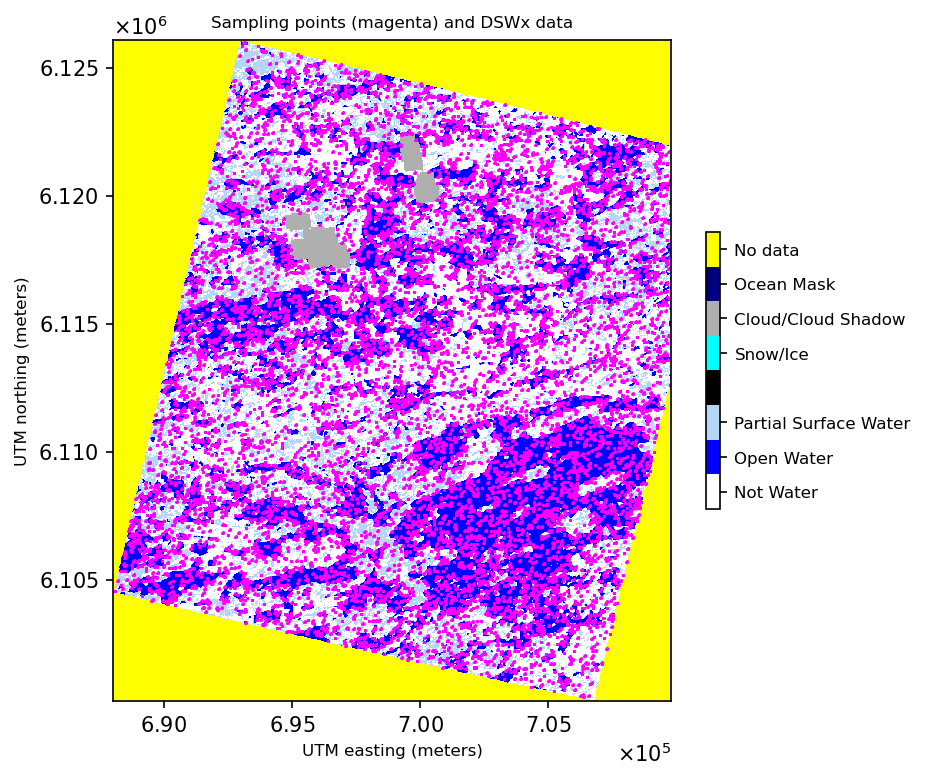

In [29]:
fontSize=7
fontSizeTitle=8
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=150)

colormap.update({255:(255, 255, 0, 255)}) # set "no data" as 'yellow' in RGBA format
cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])
bounds =  [0, 1, 2, 3, 251, 252, 253, 254, 255]
norm = colors.BoundaryNorm(bounds, cmap.N)

out = show(X_dswx,
     cmap=cmap,
     transform=X_dswx_out_meta['transform'],
     interpolation='none',
     ax=ax,vmin=0,vmax=255)

df_samples.to_crs(X_dswx_out_meta['crs']).boundary.plot(ax=ax, color='magenta',alpha=1)
ax.set_title('Sampling points (magenta) and DSWx data',fontsize=8)
ax.ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
plt.xlabel('UTM easting (meters)',fontsize=8)
plt.ylabel('UTM northing (meters)',fontsize=8)

im_dswx = out.get_images()[0]

# draw colorbar
cbar=fig.colorbar(im_dswx, ax=ax, shrink=0.4, boundaries=bounds, cmap=cmap, ticks=[0.5, 1.5, 2.5, 251.5, 252.5, 253.5, 254.5])
cbar.set_ticklabels(['Not Water', 'Open Water','Partial Surface Water','Snow/Ice','Cloud/Cloud Shadow', 'Ocean Mask', 'No data'],fontsize=8)

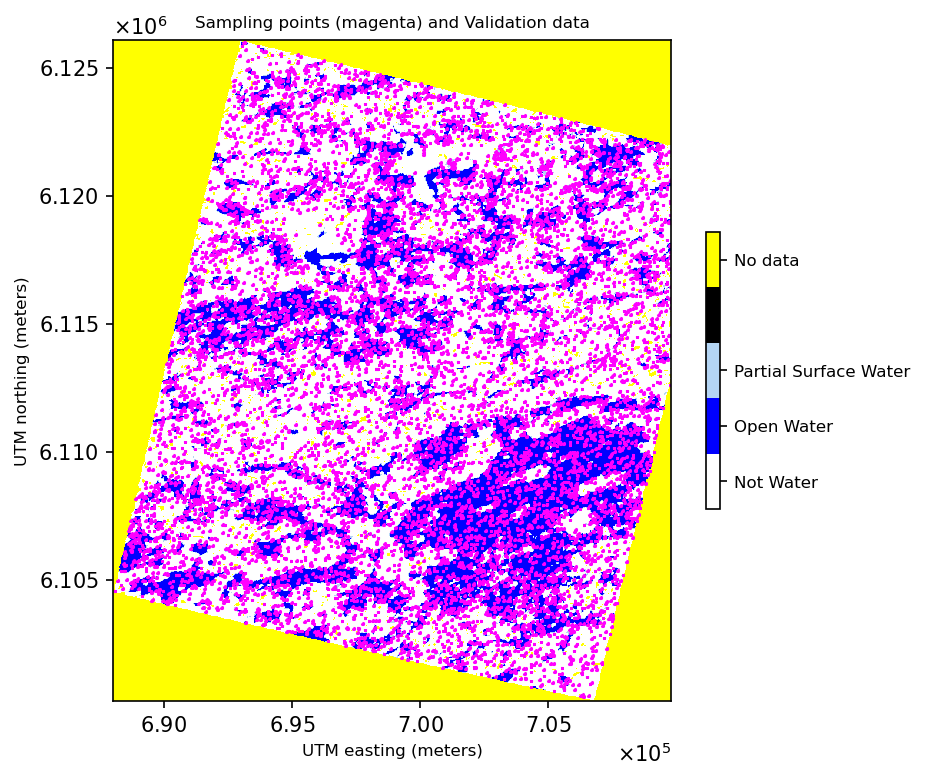

In [30]:
# setting up the colormap/colorbar
cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])
bounds =  [0, 1, 2, 3, 254, 255]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=150)
out = show(X_val_r, cmap=cmap, transform = X_dswx_out_meta['transform'], 
            interpolation='none', ax=ax, vmin=0, vmax=255)

df_samples.to_crs(X_dswx_out_meta['crs']).boundary.plot(ax=ax, color='magenta',alpha=1)

ax.set_title('Sampling points (magenta) and Validation data',fontsize=8)
ax.ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
plt.xlabel('UTM easting (meters)',fontsize=8)
plt.ylabel('UTM northing (meters)',fontsize=8)

im_val = out.get_images()[0]

# draw colorbar
cbar=fig.colorbar(im_val, ax=ax, shrink=0.4, boundaries=bounds, cmap=cmap, ticks=[0.5, 1.5, 2.5, 254.5])
cbar.set_ticklabels(['Not Water', 'Open Water', 'Partial Surface Water', 'No data'],fontsize=8)

In [31]:
class_dict = {0: 'Not_Water',
              1: 'Open_Surface_Water', 
              2: 'Partial_Surface_Water'}

y_val = np.array([[label for ind in stratified_selection[random_sample] for label in validation_hls_pixels[ind]]
                  for random_sample in range(NUMBER_OF_RANDOM_SAMPLES)
                 ])
y_dswx = np.array([[label for ind in stratified_selection[random_sample] for label in dswx_hls_pixels[ind]]
                   for random_sample in range(NUMBER_OF_RANDOM_SAMPLES)
                  ])

In [32]:
def get_acc_per_class(y_val, y_dswx):
    acc_per_class = {}
    for c in [0, 1, 2]:
        y_val_temp = y_val.copy()
        y_dswx_temp = y_dswx.copy()

        y_val_temp[y_val_temp != c] = 255
        y_dswx_temp[y_dswx_temp != c] = 255

        acc_per_class[f'acc_per_class.{class_dict[c]}'] = (y_val_temp == y_dswx_temp).sum() / y_dswx.size
    return acc_per_class

def get_binary_water_acc(y_val, y_dswx):
    
    y_val_temp = y_val.copy()
    y_dswx_temp = y_dswx.copy()

    y_val_temp[~np.isin(y_val_temp, [1, 2])] = 255
    y_val_temp[np.isin(y_val_temp, [1, 2])] = 1

    y_dswx_temp[~np.isin(y_dswx_temp, [1, 2])] = 255
    y_dswx_temp[np.isin(y_dswx_temp, [1, 2])] = 1

    binary_water_acc = (y_val_temp == y_dswx_temp).sum() / y_dswx.size
    return binary_water_acc

def get_prec_recall_score(y_val, y_dswx):

    # if no samples, we will assume perfect classification
    prec, recall, f1, supp = sklearn.metrics.precision_recall_fscore_support(y_val, y_dswx, labels=[0, 1, 2], zero_division=1)
        
    recall_per_class = {class_dict[label]: recall[label] for label in [0, 1, 2]}
    prec_per_class = {class_dict[label]: prec[label] for label in [0, 1, 2]}
    f1_per_class = {class_dict[label]: f1[label] for label in [0, 1, 2]}
    supp_per_class = {class_dict[label]: int(supp[label]) for label in [0, 1, 2]}
    binary_water_acc = get_binary_water_acc(y_val, y_dswx)
    return {
            'precision': prec_per_class,
            'recall': recall_per_class,
            'f1_per_class': f1_per_class,
            'supp_per_class':supp_per_class,
            'binary_water_acc': binary_water_acc}

def get_confusion_matrix(y_val, y_dswx):
    y_dswx_str = pd.Series([class_dict[class_id] for class_id in y_dswx], name='OPERA_DSWx')
    y_val_str = pd.Series([class_dict[class_id] for class_id in y_val], name='OPERA_Validation')
    df_conf = pd.crosstab(y_val_str, y_dswx_str)
    df_conf_formatted = df_conf.astype(int)
    
    name = df_conf.index.name
    df_conf_formatted.rename(index={index: f'{index}_{name}' for index in df_conf.index}, inplace=True)
    col_name = df_conf.columns.name
    df_conf_formatted.rename(columns={col: f'{col}_{col_name}' for col in df_conf.columns}, inplace=True)
    return df_conf_formatted

def get_metrics_for_one_sample(y_val, y_dswx):
    total_acc=sklearn.metrics.accuracy_score(y_val, y_dswx)
    
    pr_dict = get_prec_recall_score(y_val, y_dswx)
    acc_per_class = get_acc_per_class(y_val, y_dswx)
    df_conf_formatted = get_confusion_matrix(y_val, y_dswx)

    return {'total_accuracy': total_acc, 
            'confusion_matrix': df_conf_formatted.to_dict(),
            **pr_dict, 
            **acc_per_class}

In [33]:
data_temp = [(y_val[k], y_dswx[k]) for k in range(NUMBER_OF_RANDOM_SAMPLES)]
metric_data = list(starmap(get_metrics_for_one_sample, tqdm(data_temp)))

df_all_samples = pd.DataFrame(json_normalize(metric_data))
df_all_samples.head()

100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


,total_accuracy,binary_water_acc,acc_per_class.Not_Water,acc_per_class.Open_Surface_Water,acc_per_class.Partial_Surface_Water,confusion_matrix.Not_Water_OPERA_DSWx.Not_Water_OPERA_Validation,confusion_matrix.Not_Water_OPERA_DSWx.Open_Surface_Water_OPERA_Validation,confusion_matrix.Not_Water_OPERA_DSWx.Partial_Surface_Water_OPERA_Validation,confusion_matrix.Open_Surface_Water_OPERA_DSWx.Not_Water_OPERA_Validation,confusion_matrix.Open_Surface_Water_OPERA_DSWx.Open_Surface_Water_OPERA_Validation,...,precision.Partial_Surface_Water,recall.Not_Water,recall.Open_Surface_Water,recall.Partial_Surface_Water,f1_per_class.Not_Water,f1_per_class.Open_Surface_Water,f1_per_class.Partial_Surface_Water,supp_per_class.Not_Water,supp_per_class.Open_Surface_Water,supp_per_class.Partial_Surface_Water
0,0.606833,0.862500,0.862500,0.740000,0.611167,2631,6,275,46,3990,...,0.332495,0.65775,0.99750,0.16525,0.761285,0.718919,0.220775,4000,4000,4000
1,0.614833,0.868750,0.868750,0.740750,0.620167,2735,3,307,61,3991,...,0.350161,0.68375,0.99775,0.16300,0.776437,0.719553,0.222450,4000,4000,4000
2,0.606500,0.864167,0.864167,0.738250,0.610583,2650,5,275,44,3995,...,0.326457,0.66250,0.99875,0.15825,0.764791,0.717815,0.213167,4000,4000,4000
3,0.608500,0.862833,0.862833,0.741333,0.612833,2659,3,302,49,3996,...,0.333505,0.66475,0.99900,0.16175,0.763642,0.720260,0.217845,4000,4000,4000
4,0.616333,0.871833,0.871833,0.739417,0.621417,2748,8,278,53,3988,...,0.354267,0.68700,0.99700,0.16500,0.781348,0.718364,0.225141,4000,4000,4000


In [34]:
df_sample_stats = df_all_samples.aggregate(['mean', 'std'])

# includes new column with `*.std` and `*.mean`
temp_data = df_sample_stats.to_dict()
df_sample_stats = pd.json_normalize(temp_data)
stat_records = df_sample_stats.to_dict('records')[0]
df_sample_stats

,total_accuracy.mean,total_accuracy.std,binary_water_acc.mean,binary_water_acc.std,acc_per_class.Not_Water.mean,acc_per_class.Not_Water.std,acc_per_class.Open_Surface_Water.mean,acc_per_class.Open_Surface_Water.std,acc_per_class.Partial_Surface_Water.mean,acc_per_class.Partial_Surface_Water.std,...,f1_per_class.Open_Surface_Water.mean,f1_per_class.Open_Surface_Water.std,f1_per_class.Partial_Surface_Water.mean,f1_per_class.Partial_Surface_Water.std,supp_per_class.Not_Water.mean,supp_per_class.Not_Water.std,supp_per_class.Open_Surface_Water.mean,supp_per_class.Open_Surface_Water.std,supp_per_class.Partial_Surface_Water.mean,supp_per_class.Partial_Surface_Water.std
0,0.609882,0.003223,0.865178,0.002898,0.865178,0.002898,0.73975,0.002124,0.614837,0.00319,...,0.718722,0.001688,0.218631,0.006147,4000.0,0.0,4000.0,0.0,4000.0,0.0


In [35]:
COLUMNS = [col for col in df_all_samples.columns
           if ((('total_accuracy' in col) or
           ('precision' in col) or
           ('recall' in col) or
           ('f1' in col) or
           ('supp' in col)
            ) and
           ('Not_Water') not in col)]


COLUMN_RENAME = {'total_accuracy': 'Total Accuracy (All)',
                 'precision.Open_Surface_Water': 'Precision (OSW)',
                 'acc_per_class.Open_Surface_Water': 'Binary Accuracy (OSW)',
                 'acc_per_class.Partial_Surface_Water': 'Binary Accuracy (PSW)',
                 'precision.Partial_Surface_Water': 'Precision (PSW)',
                 'recall.Open_Surface_Water': 'Recall (OSW)',
                 'recall.Partial_Surface_Water': 'Recall (PSW)',
                 'supp_per_class.Open_Surface_Water': 'Support (Val) (OSW)',
                 'supp_per_class.Partial_Surface_Water': 'Support (Val) (PSW)',
                 'f1_per_class.Open_Surface_Water': 'F1 (OSW)',
                 'f1_per_class.Partial_Surface_Water': 'F1 (PSW)'}

df_temp = df_all_samples[COLUMNS].agg(['mean', 'median', 'std'])
df_temp.rename(columns=COLUMN_RENAME, inplace=True)

cols_not_supp = [col for col in df_temp.columns if 'Support' not in col]
df_temp[cols_not_supp] = df_temp[cols_not_supp] * 100

df_f = df_temp.T
df_f = df_f.round(2).astype(str)

df_f = df_f.reset_index(drop=False)
df_f = df_f.rename(columns={'index': 'Metric'})
df_f['Class'] = df_f.Metric.map(lambda m: m[-4:-1])
df_f['Metric'] = df_f.Metric.map(lambda m: m[:-6])
df_f['Metric'] = df_f.Metric.map(lambda m: m + ' ($\%$)' if 'Support' not in m else m)
df_f.sort_values(by=['Class', 'Metric'], inplace=True)
df_f = df_f.set_index(['Class', 'Metric'])
df_f.rename(columns={'mean': 'Mean', 
                     'std': 'St. Dev.', 
                     'median': 'Median'}, inplace=True)
df_f

Mean  Median St. Dev.
Class Metric                                        
All   Total Accuracy ($\%$)   60.99   60.95     0.32
OSW   F1 ($\%$)               71.87   71.88     0.17
      Precision ($\%$)        56.17   56.18      0.2
      Recall ($\%$)           99.75   99.75     0.08
      Support (Val)          4000.0  4000.0      0.0
PSW   F1 ($\%$)               21.86   21.81     0.61
      Precision ($\%$)        33.77   33.65     0.91
      Recall ($\%$)           16.17   16.16      0.5
      Support (Val)          4000.0  4000.0      0.0

In [36]:
mu_osw = stat_records['acc_per_class.Open_Surface_Water.mean']
sigma_osw = stat_records['acc_per_class.Open_Surface_Water.std']
open_surface_water_req = (mu_osw > .8 )
print('mu_osw:', mu_osw)
print('sigma_osw:', sigma_osw)
print('mu_osw - sigma_osw: ', mu_osw - sigma_osw)
open_surface_water_req

mu_osw: 0.7397499999999999
sigma_osw: 0.002123898010955975
mu_osw - sigma_osw:  0.7376261019890439


False

In [37]:
mu_psw = stat_records['acc_per_class.Partial_Surface_Water.mean']
sigma_psw = stat_records['acc_per_class.Partial_Surface_Water.std']
partial_surface_water_req = (mu_psw > .7 )
print('mu_psw:', mu_psw)
print('sigma_psw:', sigma_psw)
print('mu_psw - sigma_psw: ', mu_psw)
partial_surface_water_req

mu_psw: 0.6148374999999999
sigma_psw: 0.0031897830504739482
mu_psw - sigma_psw:  0.6148374999999999


False

In [38]:
stats_data = df_sample_stats.to_dict('records')[0]
bw_mu = stats_data['binary_water_acc.mean']
bw_std = stats_data['binary_water_acc.std']

In [39]:
formatted_not_pass = "\\textcolor{red}{Not Passed}"
formatted_pass = "\\textcolor{green}{Passed}"

old_validation_results = Path('../data/original_verification_results.csv')
old_df = pd.read_csv(old_validation_results)
old_df[old_df['planet_id']==PLANET_ID]
old_osw_result = old_df[old_df['planet_id']==PLANET_ID].surface_water.values[0]
old_psw_result = old_df[old_df['planet_id']==PLANET_ID].partial_surface_water.values[0]
old_osw_result = formatted_pass if old_osw_result else formatted_not_pass
old_psw_result = formatted_pass if old_psw_result else formatted_not_pass

In [40]:
psw_str = f'{partial_surface_water_req} ({mu_psw:1.2f})'
osw_str = f'{open_surface_water_req} ({mu_osw:1.2f})'
df_requirement = pd.DataFrame([{'Class': 'PSW',
                                'OPERA Req.': partial_surface_water_req,
                                'Accuracy ($\%$)': f'{mu_psw * 100:1.2f} ({sigma_psw * 100:1.2f})'},
                               {'Class': 'OSW',
                                'OPERA Req.': open_surface_water_req,
                                'Accuracy ($\%$)': f'{mu_osw * 100:1.2f} ({sigma_osw * 100:1.2f})'},
                               {'Class': 'Binary Water',
                                'OPERA Req.': 'N/A',
                                'Accuracy ($\%$)': f'{bw_mu * 100:1.2f} ({bw_std * 100:1.2f})'}
                              ])
df_requirement_tex = df_requirement.copy()

def labeler(val):
    if val:
        if val != 'N/A':
            return 'Passed'
        else:
            return val
    return 'Not Passed'

def labeler_for_tex(val):
    if val:
        if val != 'N/A':
            return formatted_pass
        else:
            return val
    return formatted_not_pass

df_requirement['OPERA Req.'] = df_requirement['OPERA Req.'].map(labeler)
df_requirement_tex['New OPERA Req.'] = df_requirement_tex['OPERA Req.'].map(labeler_for_tex)
df_requirement_tex['Old OPERA Req.'] = [old_psw_result, old_osw_result, 'N/A']

df_requirement_tex['Old Accuracy ($\%$)'] = [f"{old_accuracy_psw_mean} ({old_accuracy_psw_std})", f"{old_accuracy_osw_mean} ({old_accuracy_osw_std})", f"{old_accuracy_bwater_acc_mean} ({old_accuracy_bwater_acc_std})"]
df_requirement_tex['New Accuracy ($\%$)'] = df_requirement_tex['Accuracy ($\%$)'].to_list()

df_requirement_tex = df_requirement_tex.drop(['OPERA Req.', 'Accuracy ($\%$)'], axis=1)

df_requirement_tex = df_requirement_tex[['Class', 'Old OPERA Req.', 'New OPERA Req.', 'Old Accuracy ($\%$)', 'New Accuracy ($\%$)']]

In [41]:
df_requirement_tex

,Class,Old OPERA Req.,New OPERA Req.,Old Accuracy ($\%$),New Accuracy ($\%$)
0,PSW,\textcolor{red}{Not Passed},\textcolor{red}{Not Passed},59.21 (0.96),61.48 (0.32)
1,OSW,\textcolor{red}{Not Passed},\textcolor{red}{Not Passed},68.66 (0.66),73.97 (0.21)
2,Binary Water,N/A,N/A,88.45 (0.81),86.52 (0.29)


In [42]:
df_requirement

,Class,OPERA Req.,Accuracy ($\%$)
0,PSW,Not Passed,61.48 (0.32)
1,OSW,Not Passed,73.97 (0.21)
2,Binary Water,N/A,86.52 (0.29)


### Presentation material
Make plots and dataframes for final report

In [43]:
# folder for figure and TeX files
latex_folder = Path('../latex') / PLANET_ID
latex_folder.mkdir(exist_ok=True, parents=True)

In [44]:
# create a dataframe with the geometry of the validation data
with rasterio.open(val_files) as ds:
    crs = ds.crs
    mask_ = ds.read(1) != ds.profile['nodata']
    transform = ds.transform

shapes = features.shapes(mask_.astype(np.uint8), mask=mask_, transform=transform)
val_gdf = gpd.GeoDataFrame(geometry=[unary_union([Polygon(s[0]['coordinates'][0]) for s in shapes])], crs=crs).to_crs('epsg:4326')

# create a dataframe with the geometry of the rf output
with rasterio.open(classification_file) as ds:
    crs = ds.crs
    mask_ = ds.read(1) != ds.profile['nodata']
    transform = ds.transform

shapes = features.shapes(mask_.astype(np.uint8), mask=mask_, transform=transform)
exp_val_gdf = gpd.GeoDataFrame(geometry=[unary_union([Polygon(s[0]['coordinates'][0]) for s in shapes])], crs=crs).to_crs('epsg:4326')

# create a dataframe with the geometry of the DSWx tile
with rasterio.open(dswx_file) as ds:
    crs = ds.crs
    dswx_img = ds.read(1)
    dswx_transform = ds.transform
    dswx_profile = ds.profile

shapes = features.shapes((dswx_img != dswx_profile['nodata']).astype(np.uint8), mask=dswx_img<255, transform=dswx_transform)
dswx_gdf = gpd.GeoDataFrame(geometry=[unary_union([Polygon(s[0]['coordinates'][0]) for s in shapes])], crs=crs).to_crs('epsg:4326')
intersection_gdf = gpd.GeoDataFrame(geometry=[dswx_gdf.iloc[0].geometry.intersection(exp_val_gdf.iloc[0].geometry)], crs='epsg:4326')

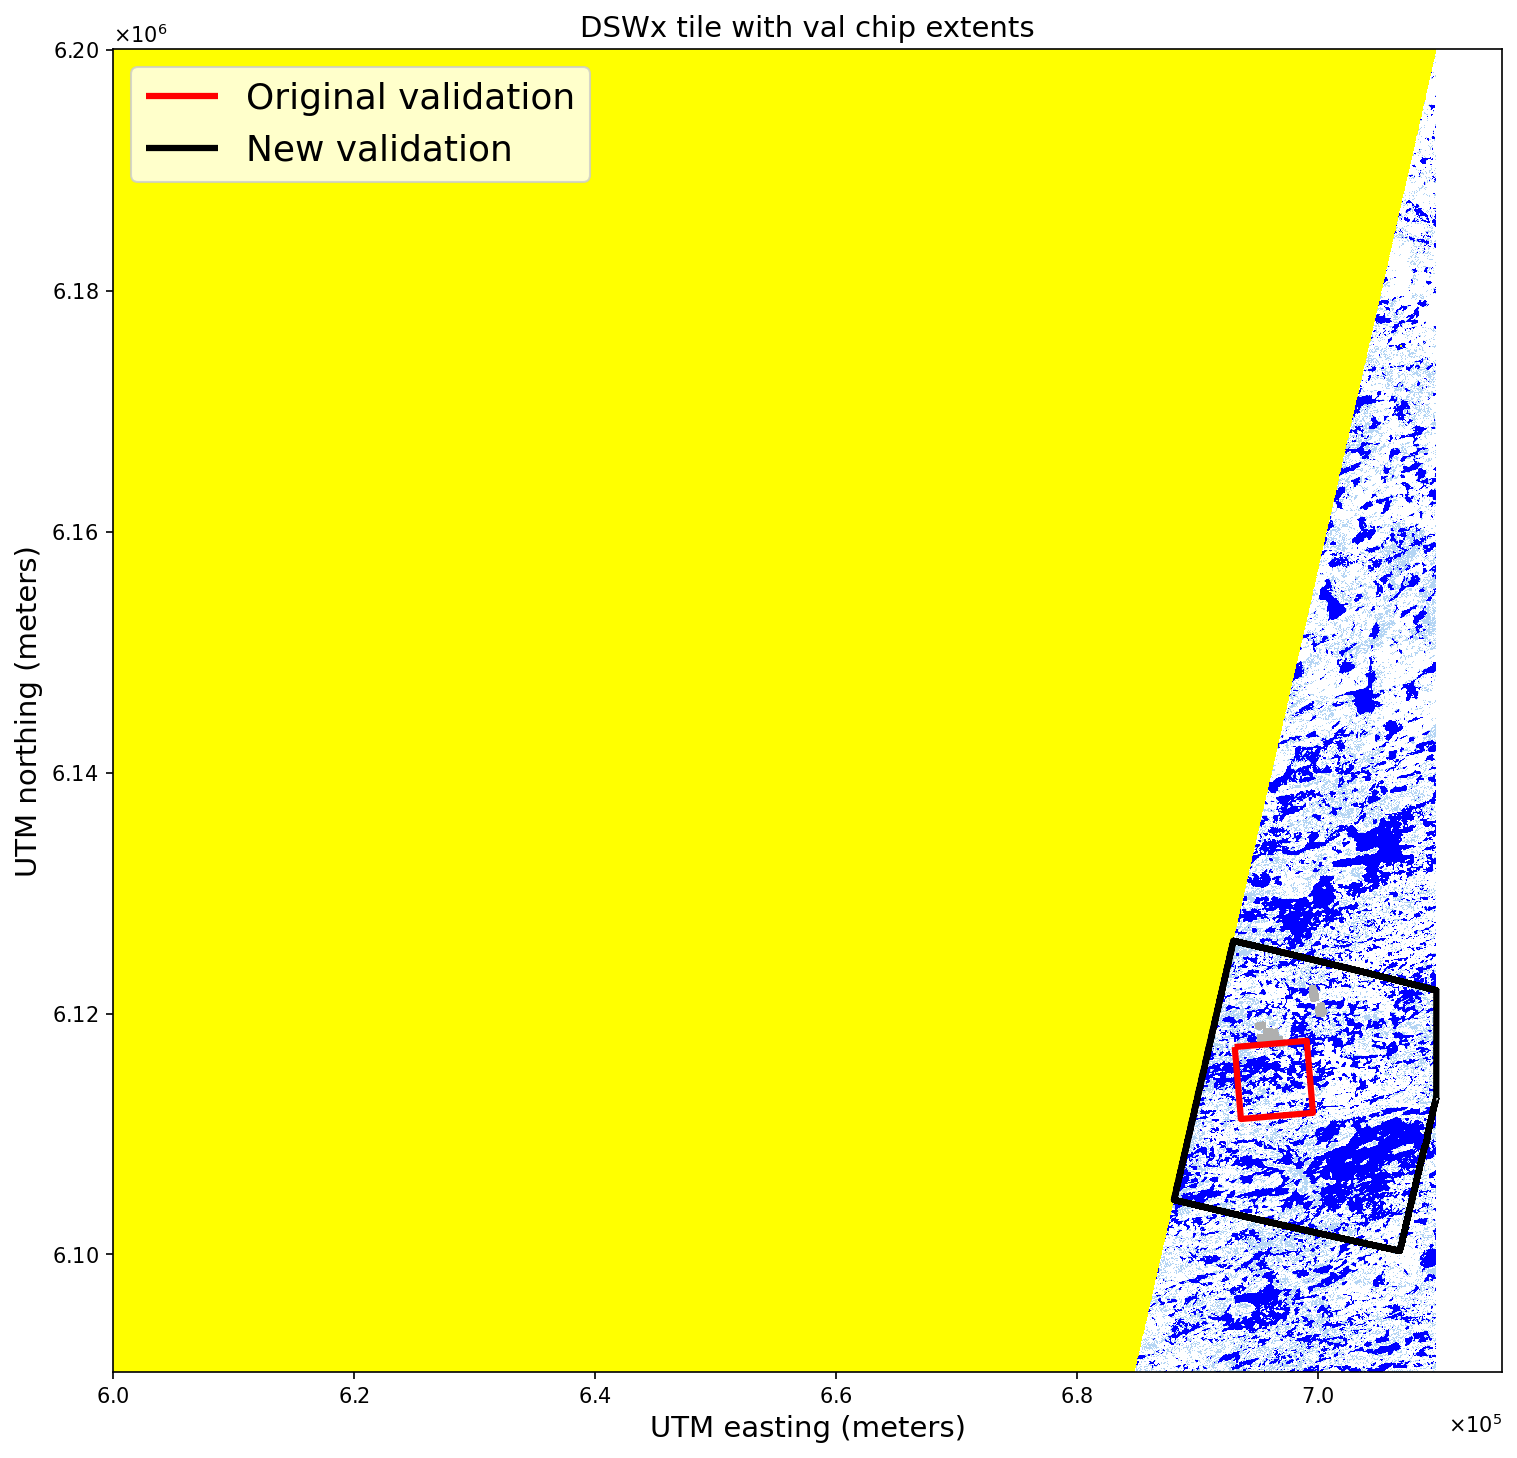

In [45]:
fontsize=14
fig, ax = plt.subplots(1, 1, figsize=(10, 10),dpi=150, layout='constrained')

# left plot
show(dswx_img, transform=dswx_transform, interpolation='none',cmap=cmap,vmin=0,vmax=255,ax=ax)
_ = val_gdf.to_crs(dswx_crs).boundary.plot(ax=ax, color='red', linewidth=3)
_ = intersection_gdf.to_crs(dswx_crs).boundary.plot(ax=ax, color='black', linewidth=3)

ax.set_title('DSWx tile with val chip extents', fontsize=fontsize)
ax.set_xlabel('UTM easting (meters)',fontsize=fontsize)
ax.set_ylabel('UTM northing (meters)',fontsize=fontsize)
ax.legend(['Original validation', 'New validation'], loc='upper left', fontsize='xx-large')
ax.ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)

In [46]:
fig.savefig(latex_folder / "chip_extents.png")

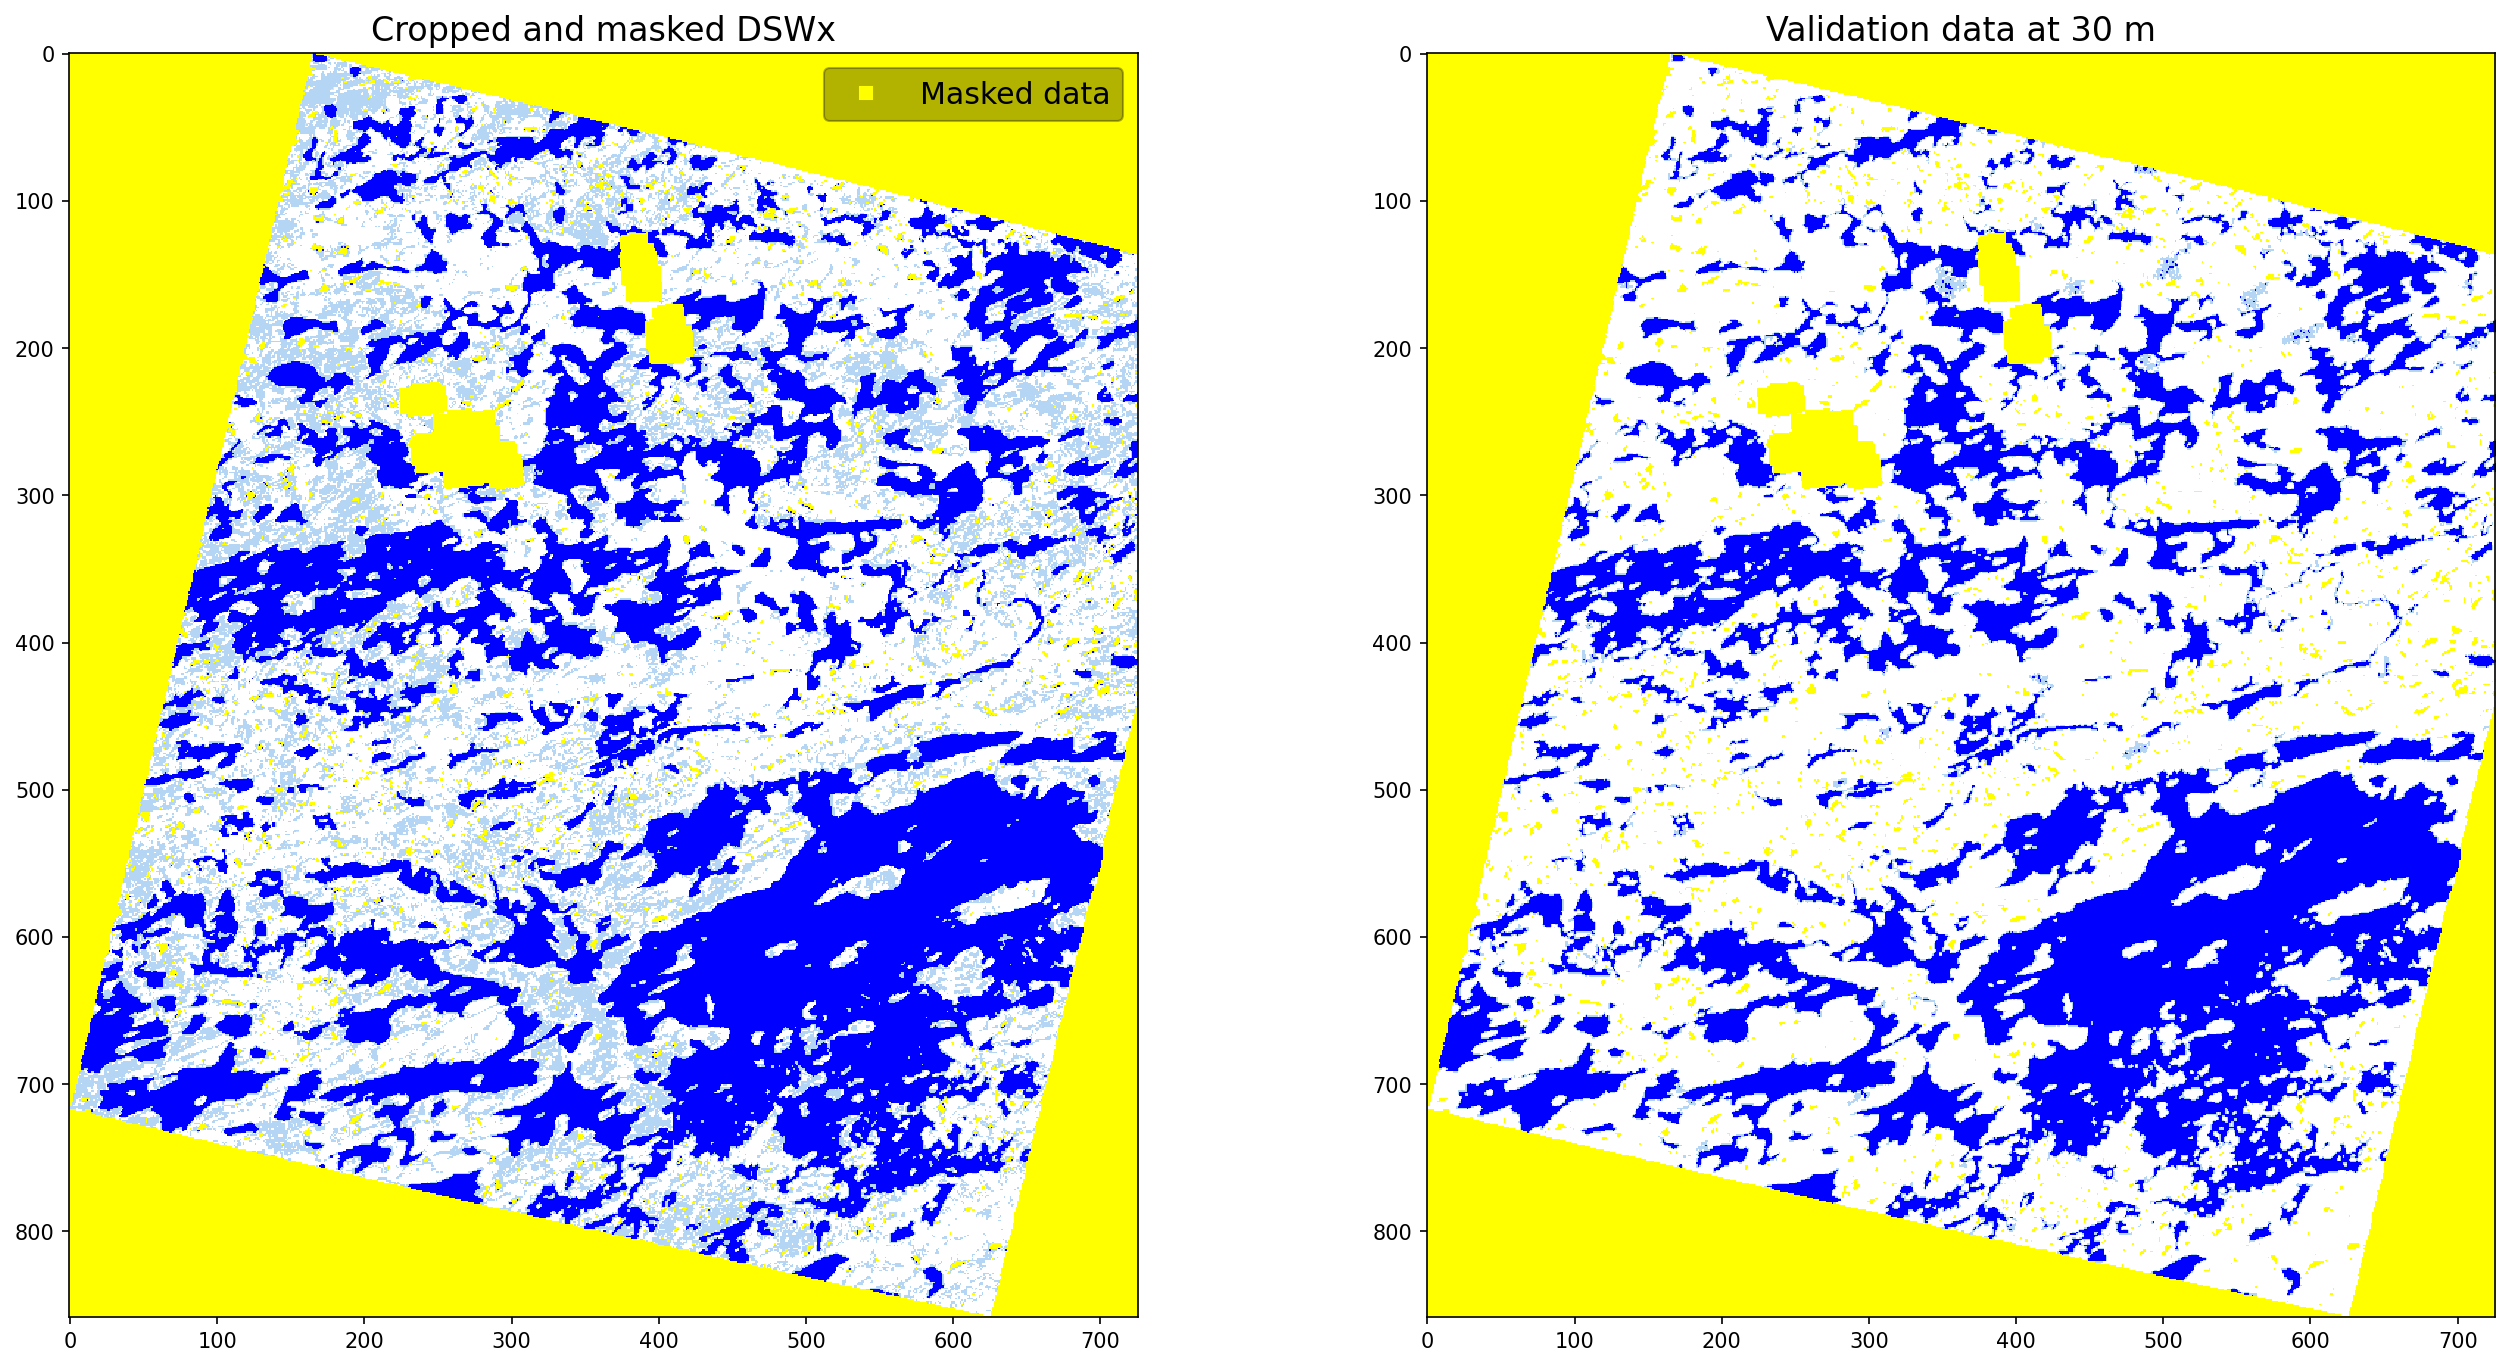

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(18, 9),dpi=150, layout='constrained')

# left plot
X_dswx_temp = X_dswx.copy()
X_dswx_temp[shared_mask] = 255
ax[0].set_title("Cropped and masked DSWx", fontsize=16)
ax[0].imshow(X_dswx_temp, cmap=cmap, interpolation='none')
ax[0].plot([], [], 's', color='yellow')
ax[0].legend(['Masked data'], loc='upper right', fontsize='x-large', framealpha=0.3, edgecolor='black', facecolor='black')

# right plot
X_val_r_temp = X_val_r.copy()
X_val_r_temp[shared_mask] = 255
ax[1].set_title("Validation data at 30 m", fontsize=16)
ax[1].imshow(X_val_r_temp, cmap=cmap, interpolation='none')

In [48]:
fig.savefig(latex_folder / "classifications.png")

In [49]:
# Calculate areas of old and new validation chips for future reference
# original validation area
with rasterio.open(dswx_file) as ds:
    test_dswx_img, X_dswx_out_transform = mask(ds, val_gdf.to_crs(ds.crs).iloc[0], crop=True)

original_val_area = np.round(30*30*np.sum(test_dswx_img <= 2)/1e6, 2)

# new validation area
new_val_area = np.round(30*30*np.sum(X_val_r_temp <= 2)/1e6, 2)

In [50]:
df_requirement.to_csv(latex_folder / "requirements.csv", index=False)
df_requirement_tex.to_latex(latex_folder / "requirements.tex")
df_f.to_latex(latex_folder / "confusion_matrix.tex")

In [51]:
area_summary = f"Validation area increased from {original_val_area} km$^2$ to {new_val_area} km$^2$"
with open(latex_folder / 'area_summary.tex', 'w') as f:
    f.write(area_summary)

In [52]:
# Calculate strata of scene because the site_ids do not necessarily reflect this
with rasterio.open(val_files) as ds:
    val_img = ds.read(1)

valid_pixels = np.sum(val_img<255)
water_pixels = np.sum(val_img==1)
water_fraction = 100*(water_pixels/valid_pixels)

if water_fraction == 0:
    old_strata = "0"
if (water_fraction > 0) and (water_fraction <= 0.08):
    old_strata = "1"
if (water_fraction > 0.08) and (water_fraction <= 2):
    old_strata = "2"
if (water_fraction > 2):
    old_strata = "3"

print(f"Water fraction & Old strata for scene: {water_fraction}, {old_strata}")

Water fraction & Old strata for scene: 36.30459347703262, 3


In [53]:
# Re-calculate strata for scene based on classification of entire planet image
valid_pixels = np.sum(X_val<255)
water_pixels = np.sum(X_val==1)
water_fraction = 100*(water_pixels/valid_pixels)

if water_fraction == 0:
    strata = "0"
if (water_fraction > 0) and (water_fraction <= 0.08):
    strata = "1"
if (water_fraction > 0.08) and (water_fraction <= 2):
    strata = "2"
if (water_fraction > 2):
    strata = "3"

print(f"Water fraction & reclassified strata for scene: {water_fraction}, {strata}")

Water fraction & reclassified strata for scene: 36.91649520065455, 3


In [54]:
new_metrics_path = Path('../latex/new_metrics.csv')
temp_df = pd.DataFrame({'planet_id':[PLANET_ID], 
    'site_name':site_name, 
    'old_strata':old_strata,
    'reclassified_strata':strata,
    'new_water_percentage':water_fraction,
    'Old_PSW_mean_accuracy':[old_accuracy_psw_mean],
    'Old_PSW_std_accuracy':[old_accuracy_psw_std],
    'Old_OSW_mean_accuracy':[old_accuracy_osw_mean],
    'Old_OSW_std_accuracy':[old_accuracy_osw_std],
    'Old_validation_area_km2' : [original_val_area], 

    'New_PSW_mean_accuracy':[np.round(100*mu_psw, 2)],
    'New_PSW_std_accuracy':[np.round(100*sigma_psw, 2)],
    'New_OSW_mean_accuracy':[np.round(100*mu_osw, 2)],
    'New_OSW_std_accuracy':[np.round(100*sigma_osw, 2)],
    'New_validation_area_km2' : [new_val_area], 
    })

if REWRITE_TO_METRICS_TABLE:
    temp_df.set_index('planet_id', inplace=True)
    
    # if metric CSV already exists, check and update appropriate row
    if new_metrics_path.exists():
        __df = pd.read_csv(new_metrics_path)
        __df.set_index('planet_id', inplace=True)
        
        # update cell values if entry already exists in dataframe
        if PLANET_ID in list(__df.index.to_list()):
            __df.update(temp_df)
        
        # add new row otherwise
        else:
            __df = pd.concat([__df, temp_df])

        # write out updated dataframe
        __df.reset_index(inplace=True)
        __df.to_csv(new_metrics_path, index=False)
    
    # create metrics CSV file if it does not exist
    else:
        temp_df.reset_index(inplace=True)
        temp_df.to_csv(new_metrics_path, index=False)

In [55]:
_df.head()

,planet_id,site_name,old_strata,reclassified_strata,new_water_percentage,Old_PSW_mean_accuracy,Old_PSW_std_accuracy,Old_OSW_mean_accuracy,Old_OSW_std_accuracy,Old_validation_area_km2,New_PSW_mean_accuracy,New_PSW_std_accuracy,New_OSW_mean_accuracy,New_OSW_std_accuracy,New_validation_area_km2
0,20210903_150800_60_2458,4_21,3,3,36.916495,59.21,0.96,68.66,0.66,35.49,61.48,0.32,73.97,0.21,401.82
1,20210903_152641_60_105c,4_11,3,3,60.523283,73.79,0.66,96.80,0.40,32.14,68.11,0.21,74.18,0.20,615.61
2,20210904_093422_44_1065,1_31,1,3,11.950334,99.98,0.05,99.99,0.03,29.83,91.75,0.02,91.90,0.03,358.08
3,20210906_101112_28_225a,3_28,2,2,0.100244,90.66,0.11,94.26,0.07,152.38,97.24,0.07,98.01,0.03,777.15
4,20210909_000649_94_222b,1_37,1,1,0.004978,100.00,0.00,100.00,0.00,36.00,99.99,0.01,99.99,0.01,725.18
